
## Decision tree regression

To run this example, you will need the following Julia packages:


In [4]:

using Kinbiont
using Plots
using Distributions
using Random
# packages to plot the tree if you do not want a plot you can skip
using AbstractTrees
using MLJDecisionTreeInterface
using TreeRecipe
using DecisionTree




###  Decision tree regression: reconstruction of antibiotics effects table
In this example, we explore how **Kinbiont.jl** can be used to simulate data about a species exposed to various antibiotics, both individually and in combination. 
We then apply a decision tree regression model to predict the growth rate of the species based on the antibiotics present in the media.

We define a transformation function that modifies the growth rate (`mu`) of the species depending on the antibiotics present in the media. This function uses a predefined concentration map:

In [19]:


function transform_abx_vector(input_vector::Vector, mu::Float64)
    concentration_map = Dict(
        (1, 0, 0) => 1.0 ,    # abx_1 -> μ
        (0, 1, 0) => 0.5 ,    # abx_2 -> 0.5μ
        (0, 0, 1) => 0.3 ,    # abx_3 -> 0.3μ
        (1, 1, 0) => 0.0 ,    # abx_1 + abx_2 -> 0μ
        (1, 0, 1) => 0.3 ,    # abx_1 + abx_3 -> 0.3μ
        (0, 1, 1) => 0.0 ,    # abx_2 + abx_3 -> 0μ
        (1, 1, 1) => 0.0,     # abx_1 + abx_2 + abx_3 -> 0.0μ
        (0, 0, 0) => 1.0      # No antibiotics -> 1.0μ
    )

    mu_correct = concentration_map[Tuple(input_vector[2:end])] * mu   # Default to 0μ if not found
    return mu_correct
end


transform_abx_vector (generic function with 1 method)


The concentration map defines how the growth rate (`mu`) is modified for different combinations of antibiotics. Here is a table of the concentration values used in the simulation:

| Antibiotic 1 | Antibiotic 2 | Antibiotic 3 | Growth Rate Scaling (μ) |
|--------------|--------------|--------------|-----------------|
| 1            | 0            | 0            | 1.0             |
| 0            | 1            | 0            | 0.5             |
| 0            | 0            | 1            | 0.3             |
| 1            | 1            | 0            | 0.0             |
| 1            | 0            | 1            | 0.3             |
| 0            | 1            | 1            | 0.0             |
| 1            | 1            | 1            | 0.0             |
| 0            | 0            | 0            | 1.0             |


We generate a random binary matrix representing the combinations of antibiotics present in each experiment and we set simulation parameters.



In [20]:

# Generate random antibiotic combinations
cols = 3;
n_experiment = 100;
random_matrix = rand(0:1, n_experiment, cols);
labels = string.(1:1:n_experiment);
random_matrix = hcat(labels, random_matrix);

# Define parameters for simulation
p_sim = [0.05, 1.0, 50.0, 1.0];
psim_1_0 = p_sim[1];

# Simulation settings
t_min = 0.0;
t_max = 800.0;
n_start = [0.1];
delta_t = 10.0;
noise_value = 0.03;
random_matrix



100×4 Matrix{Any}:
 "1"    1  0  1
 "2"    0  1  1
 "3"    1  0  0
 "4"    1  1  0
 "5"    1  0  0
 "6"    1  1  1
 "7"    0  1  1
 "8"    0  1  1
 "9"    1  1  1
 "10"   1  1  0
 ⋮            
 "92"   0  1  0
 "93"   1  0  1
 "94"   1  0  1
 "95"   0  1  1
 "96"   1  0  0
 "97"   0  0  1
 "98"   0  1  0
 "99"   0  0  0
 "100"  0  1  1


We initialize the model, the guess, and the bounds to fit and the array to store the results:



In [21]:


# We initialize the array for the results
results_fit = Any;

# We initialize the model, the guess, and the bounds to fit

ODE_models = "baranyi_richards";

ub_1 = [0.2, 5.1, 500.0, 5.0];
lb_1 = [0.0001, 0.2, 0.00, 0.2];
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2;




For each experiment, the antibiotic effect is applied, the data is simulated using **Kinbiont**, and noise is added to the data. The resulting data is then fitted to an ODE model (`baranyi_richards`).



In [22]:

for f in 1:size(random_matrix)[1]
    p_sim[1] = transform_abx_vector(random_matrix[f, :], psim_1_0)

    # Run simulation with Kinbiont
    sim = Kinbiont.ODE_sim("baranyi_richards", n_start, t_min, t_max, delta_t, p_sim)

    # Add noise to simulation results
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(sim.t))

    # Collect data
    data_t = reduce(hcat, sim.t)
    data_o = reduce(hcat, sim.u)
    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform


    # Fit the ODE model
    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(random_matrix[f, 1]),
        "test_ODE",
        ODE_models,
        p1_guess;
        lb=lb_1,
        ub=ub_1
    )


    # Store results
    if f == 1
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end





Once we have the fitted results, we use a decision tree regression model to predict the growth rate based on the antibiotic combinations. We set the parameters for the decision tree and perform cross-validation.



In [23]:
# Parameters of the decision tree
n_folds = 10;
depth = -1 ; # No depth limit

# Set random seed for reproducibility
seed = Random.seed!(1234);

# Generating feature matrix
feature_matrix = vcat(["label" "abx_1" "abx_2" "abx_3"], random_matrix);

# Decision tree regression
dt_gr = Kinbiont.downstream_decision_tree_regression(results_fit,
        feature_matrix,
        4;  # Row to learn
        do_pruning=false,
        verbose=true,
        do_cross_validation=true,
        max_depth=depth,
        n_folds_cv=n_folds,
        seed=seed
    )



Fold 1
Mean Squared Error:     0.00019794956190135243
Correlation Coeff:      0.9074186704041928
Coeff of Determination: 0.8035328486361326

Fold 2
Mean Squared Error:     0.00021505356880657816
Correlation Coeff:      0.9245343706778728
Coeff of Determination: -0.26098444752764904

Fold 3
Mean Squared Error:     0.0002556366138915983
Correlation Coeff:      0.7911575901444462
Coeff of Determination: 0.5621222892611275

Fold 4
Mean Squared Error:     0.00041010392303267784
Correlation Coeff:      0.8097996406310687
Coeff of Determination: 0.6334981197233944

Fold 5
Mean Squared Error:     0.00016446554801705904
Correlation Coeff:      0.9111927591116749
Coeff of Determination: 0.7440581647530167

Fold 6
Mean Squared Error:     0.0003927976546168224
Correlation Coeff:      0.7929321173675205
Coeff of Determination: 0.6198926517366137

Fold 7
Mean Squared Error:     9.00004254466344e-5
Correlation Coeff:      0.8383114460817266
Coeff of Determination: 0.5955173583787517

Fold 8
Mean Squ

(Decision Tree
Leaves: 8
Depth:  3, [7.14994926165856e-5, 0.00029090205239653123, 0.000261476739572059], [4.0, 1.0, 2.0], [0.8035328486361326, -0.26098444752764904, 0.5621222892611275, 0.6334981197233944, 0.7440581647530167, 0.6198926517366137, 0.5955173583787517, 0.6678136015043927, 0.8301804893964608, 0.5828709115094968], Any["values" 1.0 … 8.0 8.0; "cluster" 0.03656507659553941 … 0.0001510508790560045 0.0001000000000000417])



The result (tree, cross validation R^2 and importance score) are stored into dt_gr[1],dt_gr[2] and dt_gr[3]



In [ ]:
# meta tree


dt_gr[1]


Decision Tree
Leaves: 8
Depth:  3

In [ ]:
# Importance score of features

dt_gr[2]


3-element Vector{Float64}:
 7.14994926165856e-5
 0.00029090205239653123
 0.000261476739572059

In [27]:
# Importance rank of features

dt_gr[3]

3-element Vector{Float64}:
 4.0
 1.0
 2.0

In [28]:
# cross validation results
dt_gr[4]

10-element Vector{Float64}:
  0.8035328486361326
 -0.26098444752764904
  0.5621222892611275
  0.6334981197233944
  0.7440581647530167
  0.6198926517366137
  0.5955173583787517
  0.6678136015043927
  0.8301804893964608
  0.5828709115094968

For a basic visualization of the tree you can digit


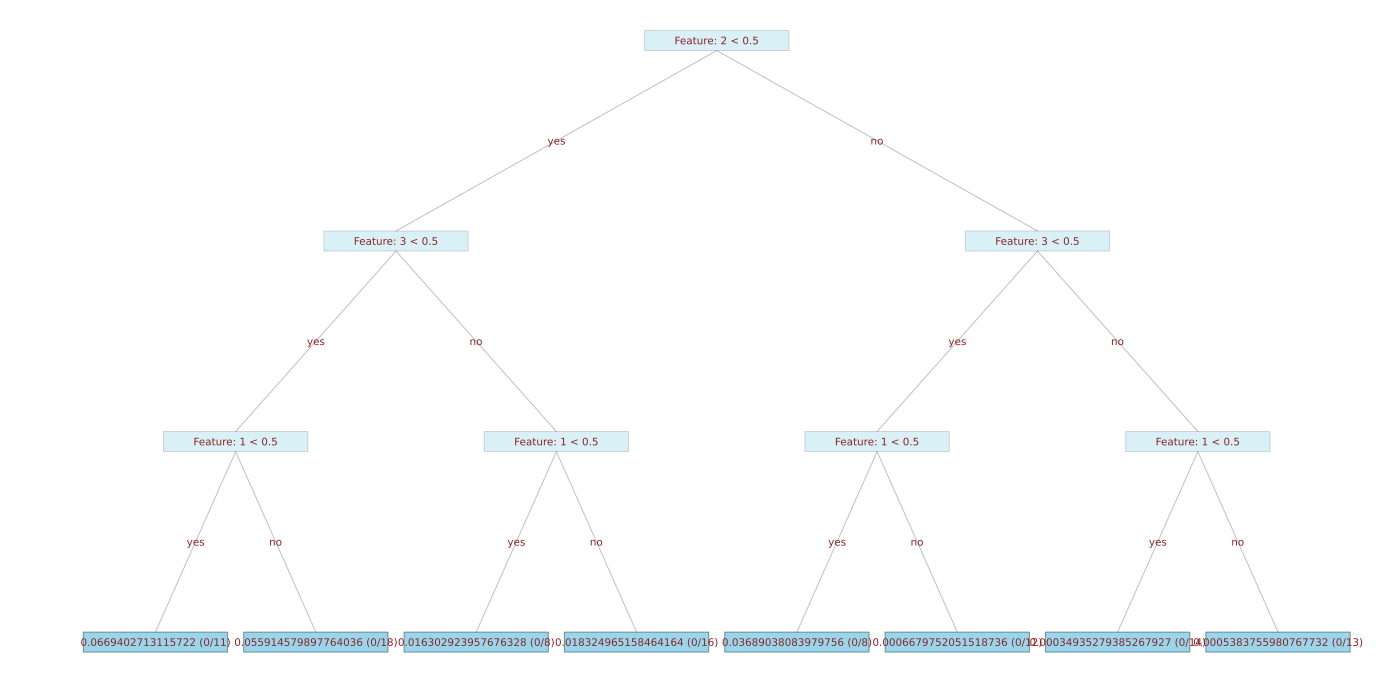

In [30]:

# Visualizing the decision tree
wt = DecisionTree.wrap(dt_gr[1])
p2 = Plots.plot(wt, 0.9, 0.2; size=(1400, 700), connect_labels=["yes", "no"])

